In [91]:
import pandas as pd
import numpy as np
np.random.seed(2018)

from collections import defaultdict

from sklearn.model_selection import GroupKFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


#boosting models => advanced options
import xgboost as xgb
#import catboost as ctb

import re
from tqdm import tqdm

from sklearn.metrics import mean_squared_log_error as msle

import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
df_train = pd.read_csv('../train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('../test.csv', parse_dates=['datetime'])

In [93]:
def get_feats(df, black_list=['count', 'casual', 'registered']):
    feats = df.select_dtypes(include=[np.int64, np.float64]).columns.values
    
    def allow_feat(feat):
        for block_feat in black_list:
            if block_feat in feat: return False
        return True
    
    return [feat for feat in feats if allow_feat(feat) ]

get_feats(df_train)

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [94]:
def custom_validation(df, feats, target_variable='count', n_folds=3):
    X = df[feats].values
    y = df[target_variable].values

    groups = df['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def get_models():
    return [
        ('dt', DecisionTreeRegressor(max_depth=5, random_state=2018)),
        ('rf', RandomForestRegressor(max_depth=8, n_estimators=50, random_state=2018)),
        ('xgb', xgb.XGBRegressor(max_depth=10, n_estimators=500, random_state=2018)),
        
    ]
        
    
def draw_importance_features(model, df, importance_type='gain'):

    fscore = model.get_booster().get_score(importance_type=importance_type) #cover, gain, weight
    maps_name = dict([ ("f{0}".format(i), col) for i, col in enumerate(df.columns)])

    impdf = pd.DataFrame([ {'feature': maps_name[k], 'importance': fscore[k]} for k in fscore ])
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['feature']

    impdf.plot(kind='bar', title='{0} - Importance Features'.format(importance_type.title()), figsize=(12, 4))
    
    
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred[y_pred<0] = 0
    return np.sqrt(msle(y_test, y_pred))

## Feature engineering

In [95]:
def feats_engineering(df, offset_log=4):
    df['year']       = df['datetime'].dt.year
    df['month']      = df['datetime'].dt.month
    df['day']        = df['datetime'].dt.day
    df['hour']       = df['datetime'].dt.hour
    df['dayofweek']  = df['datetime'].dt.dayofweek
    df['weekofyear'] = df['datetime'].dt.weekofyear
    df['weekend']    = df.dayofweek.map(lambda x: int(x in [5,6]) )
    df['dayofyear']  = df['datetime'].dt.dayofyear
    
    df['rush_hour'] = df['datetime'].apply(lambda i: min([np.fabs(9-i.hour), np.fabs(20-i.hour)]))
    df.loc[:,('rush_hour')] = df['datetime'].apply(lambda i: np.fabs(14-i.hour))
    
    df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

    if 'count' in df:
        df['count_log'] = np.log2( df['count'] + offset_log )
        df['registered_log'] = np.log2( df['registered'] + offset_log )
        df['casual_log'] = np.log2( df['casual'] + offset_log )

    return df

In [96]:
df = feats_engineering(df_train)
feats = get_feats(df)

for model_name, model in get_models():
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(df_train, feats):
        score = run_model(model, X_train, X_test, y_train, y_test)
        scores.append(score)
        
    print("Model: {0}, scores-mean: {1}, scores-std: {2}".format(model_name, np.mean(scores), np.std(scores)))

C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['datetime'].dt.weekofyear
C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)


Model: dt, scores-mean: 0.6112958509608698, scores-std: 0.013712905051673177
Model: rf, scores-mean: 0.42424461226774085, scores-std: 0.011612383663626411
Model: xgb, scores-mean: 0.42390151198401166, scores-std: 0.006553692954023589


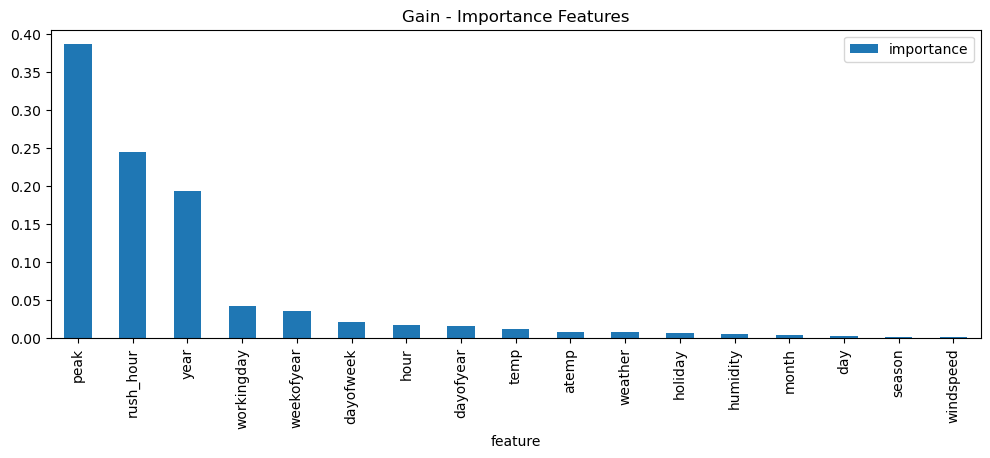

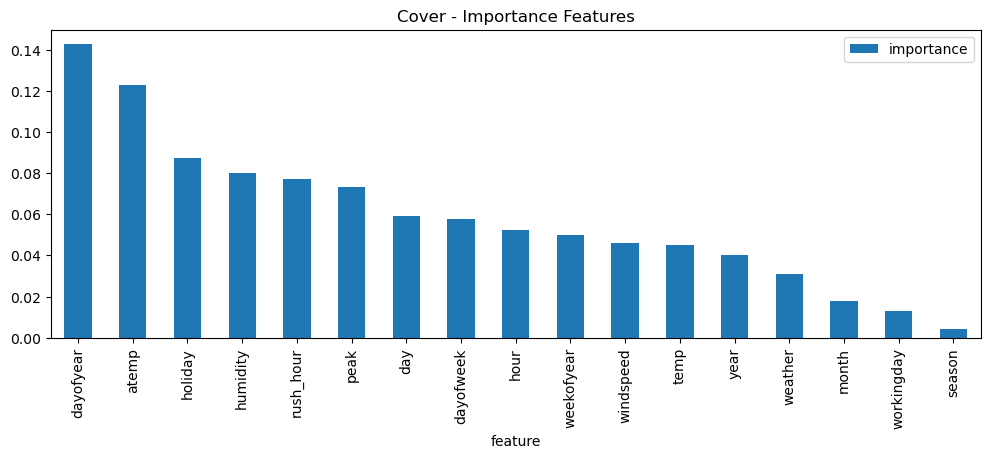

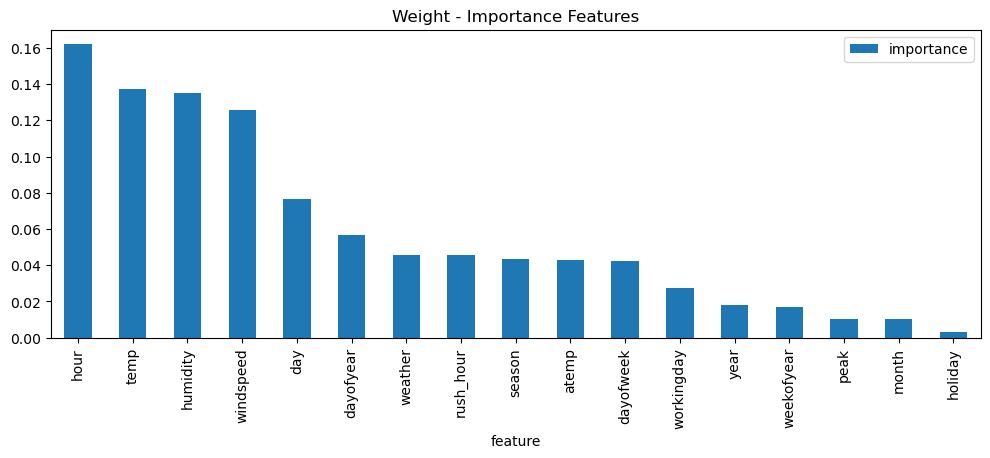

In [97]:
draw_importance_features(model, df[feats], importance_type='gain')
draw_importance_features(model, df[feats], importance_type='cover')
draw_importance_features(model, df[feats], importance_type='weight')

## Aggregation

In [105]:
df_train[ ['year', 'count'] ].groupby(['year']).median()

,count
year,
2011,111.0
2012,199.0


In [98]:
median_year = df_train[ ['year', 'count'] ].groupby(['year']).median().to_dict()['count']
df_train['year'].map(lambda x: median_year[x]).head()

0    111.0
1    111.0
2    111.0
3    111.0
4    111.0
Name: year, dtype: float64

In [99]:
agg_feats = ['year', 'hour']
agg_func = np.mean

median_hour_year = df_train[ agg_feats + ['count'] ].groupby(agg_feats).agg(agg_func).to_dict()['count']
new_feat = '{0}_{1}'.format( agg_func.__name__, "_".join(agg_feats) )
df_train[agg_feats].apply(lambda x: median_hour_year[ tuple(dict(x).values()) ], axis=1).head()

0    43.563877
1    26.831858
2    19.307692
3    10.056872
4     5.255814
dtype: float64

## Aggregation (more advanced)

In [100]:
df_train = feats_engineering(df_train)
df_test  = feats_engineering(df_test)

agg_feats = [ 
    ['hour', 'year'],
    ['hour', 'season'],
    ['hour', 'month'],
]

for agg_feat in tqdm(agg_feats):
    for agg_func in [np.mean, np.median, np.sum, np.std]:
        dict_agg = df_train[ agg_feat + ['count'] ].groupby(agg_feat).agg(agg_func).to_dict()['count']
        new_feat = '{0}_{1}'.format( agg_func.__name__, "_".join(agg_feat) )

        default_dict_val = agg_func( list(dict_agg.values()))
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

        df_train[new_feat] = df_train[agg_feat].apply(lambda x: dict_agg[ tuple(dict(x).values()) ], axis=1)
        df_test[new_feat] = df_test[agg_feat].apply(lambda x: default_dict_agg[ tuple(dict(x).values()) ], axis=1)

C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['datetime'].dt.weekofyear
C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['datetime'].dt.weekofyear
C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:14: DeprecationWarning: In future, it will be an err

In [101]:
df = feats_engineering(df_train)
feats = get_feats(df)

for model_name, model in get_models():
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(df_train, feats):
        score = run_model(model, X_train, X_test, y_train, y_test)
        scores.append(score)
        
    print("Model: {0}, scores-mean: {1}, scores-std: {2}".format(model_name, np.mean(scores), np.std(scores)))

C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['datetime'].dt.weekofyear
C:\Users\jakpi\AppData\Local\Temp\ipykernel_34928\1935081566.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)


Model: dt, scores-mean: 0.6359347094064609, scores-std: 0.025625066405889414
Model: rf, scores-mean: 0.43935814250559274, scores-std: 0.02126621247458125
Model: xgb, scores-mean: 0.41603980572130256, scores-std: 0.019811617248276597


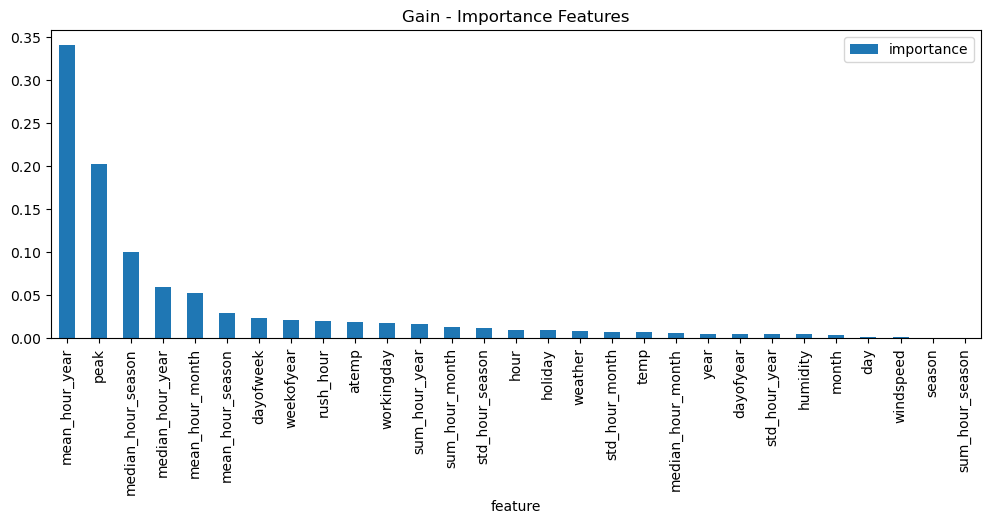

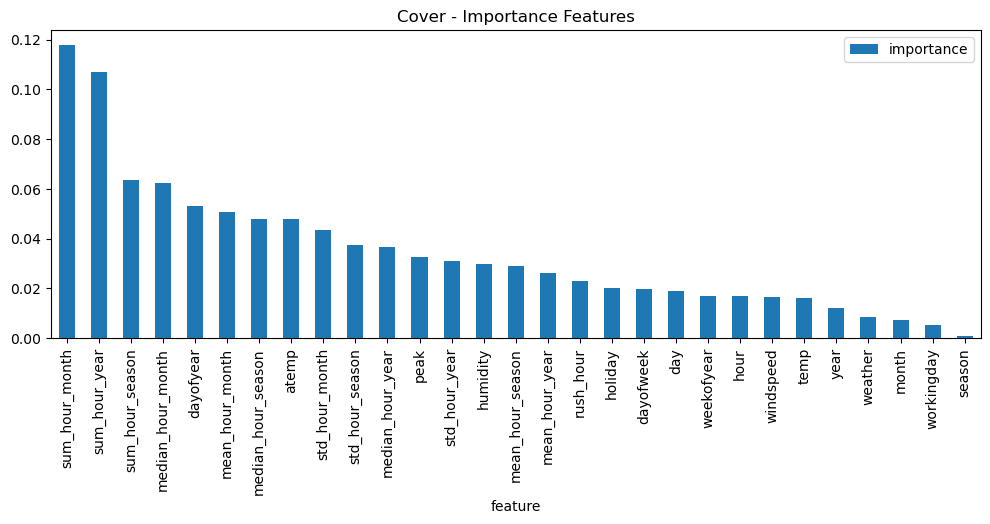

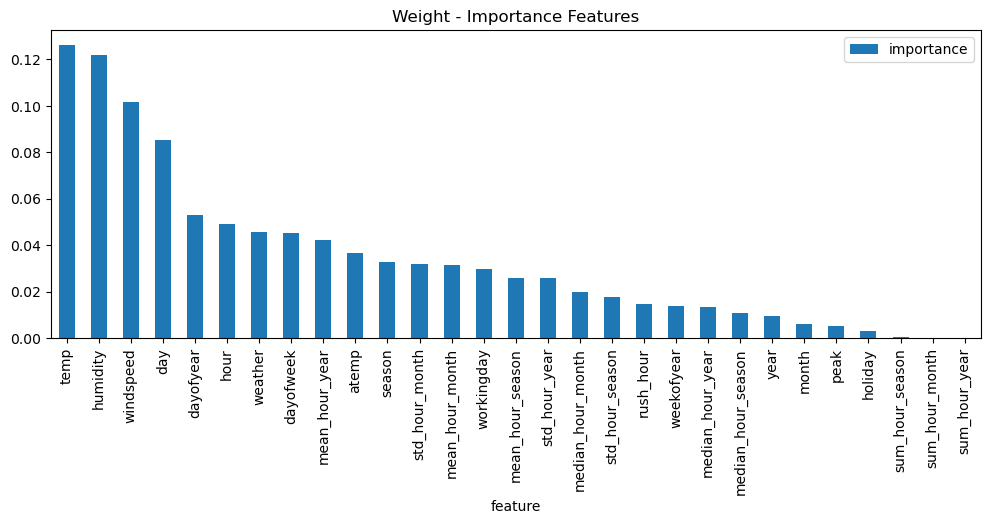

In [102]:
draw_importance_features(model, df[feats], importance_type='gain')
draw_importance_features(model, df[feats], importance_type='cover')
draw_importance_features(model, df[feats], importance_type='weight')

## Submit => 0.47117

In [103]:
X = df_test[feats].values
y_pred = model.predict(X)
y_pred[y_pred<0] = 0
df_test['count'] = y_pred
df_test[ ['datetime', 'count'] ].to_csv('../agg_xgboost.csv', index=False)

![](../images/agg_xgb_0.47117.png)